# Claims Analysis

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [38]:
import operator
import math
import random
import itertools
import json as j
from gb.hypergraph.hypergraph import HyperGraph
import gb.hypergraph.symbol as sym
import gb.hypergraph.edge as ed
import gb.nlp.parser as par
import gb.tools.json as json_tools
from gb.synonyms.meronomy import Meronomy
from gb.metrics.hyper_similarity import HyperSimilarity

import numpy as np
import matplotlib.pyplot as plt

from visJS2jupyter import visJS_module
from visJS2jupyter import visualizations
import networkx as nx

### Constants

In [3]:
MAX_PROB = -12

### HyperGraph

In [4]:
hg = HyperGraph({'backend': 'leveldb', 'hg': '../reddit-worldnews-01012013-01082017.hg'})

### Start parser

In [5]:
parser = par.Parser()

### Aux Functions

In [6]:
def rel_contains(full_edge, term):
    if sym.is_edge(full_edge) and len(full_edge) > 2 and sym.is_edge(full_edge[2]):
        rel = full_edge[0]
        if sym.is_edge(rel):
            return term in rel
        else:
            return rel == term
    return False


def edge2str(edge):
    s = ed.edge2str(edge, namespaces=False)
    if sym.is_edge(edge):
        return s

    if s[0] == '+':
        s = s[1:]

    if len(s) == 0:
        return None

    if not s[0].isalnum():
        return None

    word = parser.make_word(s)
    if word.prob < MAX_PROB:
        return s

    return None


def edge2syn(edge):
    atom = edge2str(edge)
    if atom:
        syn_id = mer.syn_id(atom)
        if syn_id:
            return syn_id
    return None

### Meronomy and Say Edges

In [7]:
mer = Meronomy(parser)

edge_data = json_tools.read('../all-reddit-worldnews-01012013-01082017.json')

say_edges = []
for it in edge_data:
    edge_ns = ed.str2edge(it['edge'])
    mer.add_edge(edge_ns)
    edge = ed.without_namespaces(edge_ns)
    
    # (says x ...)
    if rel_contains(edge, 'says'):
        say_edges.append(edge)
        
mer.generate()

### Sayers, sayers + claims & sorted sayers

In [9]:
sayers = {}
sayers_and_claims = {}
for edge in say_edges:
    sayer = edge2syn(edge[1])
    if sayer not in sayers_and_claims:
        sayers[sayer] = 0
        sayers_and_claims[sayer] = []
    sayers[sayer] += 1
    sayers_and_claims[sayer].append(edge[2])
        
sorted_sayers = sorted(sayers.items(), key=operator.itemgetter(1), reverse=True)

### Concepts by sayer

In [10]:
concepts_by_sayer = {}


def add_concepts(targ, src):
    for key in src:
        if key in targ:
            targ[key] += src[key]
        else:
            targ[key] = src[key]


def concepts_in_claim(claim, concept_map=None, deep=True):
    if not concept_map:
        concept_map = {}
    syn_id = edge2syn(claim)
    if syn_id:
        if syn_id not in concept_map:
            concept_map[syn_id] = 0
        concept_map[syn_id] += 1
        
        if deep:
            if sym.is_edge(claim):
                for item in claim[1:]:
                    concepts_in_claim(item, concept_map)
    return concept_map


def get_concepts_by_sayer(sayer, that_include=None):
    concept_map = {}
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        if not that_include:
            add_concepts(concept_map, claim_concepts)
        elif that_include in claim_concepts.keys():
            del claim_concepts[that_include]
            add_concepts(concept_map, claim_concepts)
    return concept_map


for sayer in sayers_and_claims:
    concepts_by_sayer[sayer] = get_concepts_by_sayer(sayer)

### Who talks about who graph

In [11]:
who_who = {}

actors = [sayer for sayer in sayers if sayer and len(sayers_and_claims[sayer]) > 1]
active_actors = set()

def add_edge(orig, targ):
    if orig and targ:
        if orig not in who_who:
            who_who[orig] = {}
        if targ not in who_who[orig]:
            who_who[orig][targ] = 0
        who_who[orig][targ] += 1
        if orig != targ:
            active_actors.add(orig)
            active_actors.add(targ)

for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            if concept in actors:
                add_edge(sayer, concept)
            
file = open('../who_who.gml', 'w')
file.write('graph\n[\n')
for actor in active_actors:
    # print(actor)
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(actor), mer.synonym_label(actor, short=True)))
for orig in who_who:
    for targ in who_who[orig]:
        w = who_who[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

### Concept-actor graph

In [12]:
concept_actor = {}

def add_edge(orig, targ):
    if orig and targ:
        if orig not in concept_actor:
            concept_actor[orig] = {}
        if targ not in concept_actor[orig]:
            concept_actor[orig][targ] = 0
        concept_actor[orig][targ] += 1

def actors_for_concept(concept):
    return concept_actor[concept].keys()
        
for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            add_edge(concept, sayer)

concept_metrics = {}
            
for concept in concept_actor:
    weights = [concept_actor[concept][actor] for actor in concept_actor[concept]]
    total = sum(weights)
    h_weights = [float(i) / float(total) for i in weights]
    h_weights = [i * i for i in h_weights]
    h = 1. / sum(h_weights)
    concept_metrics[concept] = {'total': total, 'h': h}

### Dispersion of Concepts amongst Actors

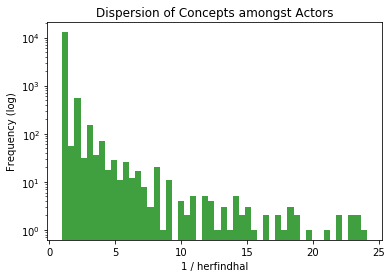

In [13]:
x = [concept_metrics[concept]['h'] for concept in concept_metrics]
x = [i for i in x if i < 25]

# the histogram of the data
n, bins, patches = plt.hist(x, 50, log=True, facecolor='green', alpha=0.75)

plt.xlabel('1 / herfindhal')
plt.ylabel('Frequency (log)')
plt.title('Dispersion of Concepts amongst Actors')

plt.show()

### Show Top Actors

In [14]:
for t in sorted_sayers[:20]:
    syn_id = t[0]
    if syn_id:
        print('%s %s %s %s' % (syn_id, mer.synonym_label(syn_id), t[1], len(concepts_by_sayer[syn_id])))

900920 {russia} 196 833
900273 {iran} 110 389
234 {(+ north korea), korea} 106 358
900780 {putin} 92 376
900161 {turkey} 70 309
900896 {ukraine} 67 227
845 {pope, francis, (+ pope francis)} 59 266
906516 {erdogan} 48 171
1357 {(+ saudi arabia), arabia, saudi} 46 199
900144 {syria} 44 154
902056 {pakistan} 42 151
900745 {france} 41 175
914895 {(+ south korea)} 38 159
801 {cameron, (+ david cameron), david} 34 122
900265 {japan} 32 157
456 {kremlin, (+the kremlin)} 31 127
39 {merkel, (+ angela merkel), angela} 31 148
900639 {trump} 30 107
900137 {eu} 27 110


### Concepts by actor

In [16]:
concepts = concepts_by_sayer[843]

sorted_concepts = sorted(concepts.items(), key=operator.itemgetter(1), reverse=True)
for t in sorted_concepts[:20]:
    syn_id = t[0]
    if syn_id:
        print('[%s] %s %s %s' % (syn_id, mer.synonym_label(syn_id, short=True), t[1], concept_metrics[syn_id]['h']))

[444413] 's amount world many conflicts 4 1.0
[843] pope francis 4 2.9999999999999996
[1917] catholic church 3 2.6666666666666665
[1889] the vatican 3 3.571428571428571
[35712] to_equate islam with violence 3 1.0
[260] on sunday 3 5.444444444444445
[1225857] the church 2 1.0
[399373] of state israel 2 1.0
[445184] migrant walls 2 1.0
[622992] of religious harmony 2 1.0
[684388] to visit nation 2 1.0
[578826] rio trip 2 1.0
[646335] and contraception marriage 2 1.0
[646377] and corruption speculation 2 1.0
[1220220] islam 2 2.6666666666666665
[703704] if maintained dignity 2 1.0
[1226925] dignity 2 1.7999999999999998
[177988] their lands.pope 2 1.0
[1220775] trump 2 28.446153846153834
[271437] its construction 2 1.0


### Concepts by actor and $1/herfindhal$

In [17]:
ego = 1221043
concepts = concepts_by_sayer[ego]

concepts_by_h = {}
for concept in concepts:
    h = int(round(concept_metrics[concept]['h']))
    if h not in concepts_by_h:
        concepts_by_h[h] = []
    concepts_by_h[h].append(concept)

for syn_id in concepts_by_h[4][:20]:
    actors = [mer.synonym_label(actor, short=True) for actor in actors_for_concept(syn_id) if actor != ego]
    actor_str = ', '.join(actors)
    print('[%s] %s %s %s {%s}' % (syn_id, mer.synonym_label(syn_id, short=True), concept_metrics[syn_id]['h'], concept_metrics[syn_id]['total'], actor_str))

[987] new york 4.0 4 {ukraine, iraq pm, belgium}
[1220458] hackers 4.5 6 {a new report, cybersecurity firm, vodafone, yahoo}
[1220267] spies 4.0 4 {putin, norway, sweden}
[1220437] poland 3.571428571428571 5 {britain, putin, defense minister}
[1222383] foreign minister 3.571428571428571 5 {iranian mp, iraq, iranian fm}
[5357] armenian genocide 4.0 4 {turkey, watch human rights, erdoğan}
[1230107] jordan 3.571428571428571 5 {syrian government, japan, the syrian army}
[1222061] in ukraine 4.499999999999999 6 {angela merkel, kiev, osce, george soros}
[16] the cia 4.5 6 {european court, wikileaks, german government, pakistan court}
[1271329] patience 3.571428571428571 5 {turkey, germany, trump}
[1243094] with u.s 4.499999999999999 6 {iran, khamenei, germany, 's lavrov russia}
[1223876] diplomatic 4.0 4 {the kremlin, turkey, russian official}
[1227262] commander 4.0 4 {hezbollah, iraqi military, iraq}
[1996] the brink 3.571428571428571 5 {north korea, france, putin}
[2056] zika virus 4.0 4 

### Alignment on concepts

In [ ]:
ego = 845         # the pope
concept = 959230  # contraception

def related_concepts(actor, concept):
    result = set()
    for claim in sayers_and_claims[actor]:
        claim_concepts = concepts_in_claim(claim)
        if concept in claim_concepts:
            for c in claim_concepts:
                if c != concept:
                    result.add(c)
    return result

actors = actors_for_concept(concept)

for actor in actors:
    actor_name = mer.synonym_label(actor, short=True)
    print('ACTOR: %s' % actor_name)
    related = related_concepts(actor, concept)
    for rel in related:
        print(mer.synonym_label(rel, short=True))

### Who talks about what - Ego Graph

In [ ]:
ego = 845
who_what = {}

concepts = concepts_by_sayer[ego]

nodes = set()

def add_edge(orig, targ, weight):
    if orig and targ:
        if orig not in who_what:
            who_what[orig] = {}
        who_what[orig][targ] = weight
        nodes.add(orig)
        nodes.add(targ)

for concept in concepts:
    if len(concept_actor[concept]) > 1:
        for actor in concept_actor[concept]:
            add_edge(actor, concept, concept_actor[concept][actor])
        
file = open('../who_what.gml', 'w')
file.write('graph\n[\n')
for node in nodes:
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(node), mer.synonym_label(node, short=True)))
for orig in who_what:
    for targ in who_what[orig]:
        w = who_what[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

In [ ]:
ego = 900574

concepts = concepts_by_sayer[ego]

file = open('../france.csv', 'w')
file.write('concept,herfindahl,total,ego_total,actors\n')
for concept in concepts:
    file.write('%s,%s,%s,%s,' % (mer.synonym_label(concept, short=True),
                                 concept_metrics[concept]['h'],
                                 concept_metrics[concept]['total'],
                                 concept_actor[concept][ego]))
    actor_str = '|'.join([mer.synonym_label(actor, short=True) for actor in concept_actor[concept] if actor != ego])
    file.write('%s\n' % actor_str)
file.write('\n')
file.close()

In [ ]:
print(mer.synonym_label(908171))
print(mer.syn_id('(+ pope francis)'))

### Concept proximity

In [18]:
hs = HyperSimilarity(hg)

global_economy = mer.syn_id('(+ global economy)')
financial_crisis = mer.syn_id('(+ financial crisis)')
catholic_church = mer.syn_id('(+ catholic church)')
pope_francis = mer.syn_id('(+ pope francis)')
hackers = mer.syn_id('hackers')
spies = mer.syn_id('spies')

# mer.synonym_full_edges(c4)

hs.synonym_similarity(mer, hackers, spies)

1.0056965782477258

In [ ]:
used_concepts = set()

for sayer in sayers_and_claims:
    used_concepts = used_concepts.union(concepts_by_sayer[sayer])

used_concepts = list(used_concepts)
    
print(len(used_concepts))

In [ ]:
random.seed()

def random_concept():
    return random.choice(used_concepts)

x = []
best_prox = -1.
best_pair = None
for i in range(1000):
    c1 = random_concept()
    c2 = random_concept()
    hs = HyperSimilarity(hg)
    prox = hs.synonym_similarity(mer, c1, c2)
    x.append(prox)
    if prox > best_prox:
        best_prox = prox
        best_pair = (c1, c2)
        print('%s | %s => %s' % (mer.synonym_label(best_pair[0], short=True), mer.synonym_label(best_pair[1], short=True), best_prox))

In [24]:
def related_concepts(main_concept, actor):
    concepts = set()
    for claim in sayers_and_claims[actor]:
        claim_concepts = concepts_in_claim(claim)
        if main_concept in claim_concepts:
            for concept in claim_concepts:
                if concept != main_concept:
                    concepts.add(concept)
    return concepts

main_concept = mer.syn_id('cia')
# main_concept = mer.syn_id('fifa')
# main_concept = mer.syn_id('hackers')
actors = actors_for_concept(main_concept)

related_concepts_by_actor = {}
for actor in actors:
    related_concepts_by_actor[actor] = related_concepts(main_concept, actor)
    
for actor in related_concepts_by_actor:
    print('ACTOR %s' % mer.synonym_label(actor, short=True))
    for concept in related_concepts_by_actor[actor]:
        print('-> %s' % mer.synonym_label(concept, short=True))

ACTOR russia
-> spying
-> moscow policeman
-> policeman
-> of former moscow policeman for spying cia
-> convicts of former moscow policeman for spying cia
-> for spying cia
-> moscow
ACTOR european court
-> polish
-> secret jail
-> ran cia secret jail in a polish forest
-> a polish forest
ACTOR wikileaks
-> infectious zero patient
-> zero patient
-> as russian activity
-> turns cia ’s servers into infectious zero patient
-> disguised hacking cia as russian activity
-> hacking cia
-> into infectious zero patient
-> cia ’s
-> russian
ACTOR german government
-> of issue cia leaks
-> cia leaks
-> leaks
-> takes it of issue cia leaks seriously
ACTOR pakistan court
-> cia station
-> former chief cia station


In [25]:
hs = HyperSimilarity(hg)

def closest_concept(orig_set, targ_set):
    best_prox = -1.
    best_pair = None
    for orig in orig_set:
        for targ in targ_set:
            prox = hs.synonym_similarity(mer, orig, targ)
            if prox > best_prox:
                best_prox = prox
                best_pair = (orig, targ)
    return best_pair, best_prox

nodes = {}
edges = []
for actor in related_concepts_by_actor:
    nodes[actor] = {'type': 'actor'}
for actor_orig in related_concepts_by_actor:
    best_prox = -1.
    best_pair = None
    for actor_targ in related_concepts_by_actor:
        if actor_orig != actor_targ:
            pair, prox = closest_concept(related_concepts_by_actor[actor_orig], related_concepts_by_actor[actor_targ])
            if prox > best_prox:
                best_prox = prox
                best_pair = pair
            pair, prox = closest_concept(related_concepts_by_actor[actor_orig], {actor_targ})
            if prox > best_prox:
                best_prox = prox
                best_pair = pair
    concept = best_pair[1]
    if concept not in related_concepts_by_actor:
        nodes[concept] = {'type': 'concept'}
    edges.append((actor_orig, concept))
    print('%s -> %s [%s]' % (mer.synonym_label(actor_orig, short=True), mer.synonym_label(concept, short=True), best_prox))

russia -> russian [7.4673124385568626]
european court -> russia [12.893179018842508]
wikileaks -> russia [27.028430726057948]
german government -> russia [34.04249599274112]
pakistan court -> european court [0.3517392232180964]


In [ ]:
G = nx.DiGraph()
for node in nodes:
    G.add_node(node)
for edge in edges:
    G.add_edge(edge[0], edge[1])
gnodes = G.nodes()
gedges = G.edges()

pos = nx.spring_layout(G)

def node_shape(n):
    if nodes[n]['type'] != 'actor':
        return 'square'
    else:
        return 'triangle'
    
def node_color(n):
    if nodes[n]['type'] != 'actor':
        return '#8A2BE2'
    else:
        return '#FFA500'

nodes_dict = [{'id': mer.synonym_label(n, short=True),
               'color': node_color(n),
               'node_shape': node_shape(n),
               'x': pos[n][0] * 1000,
               'y': pos[n][1] * 1000} for n in gnodes]
node_map = dict(zip(nodes,range(len(gnodes))))  # map to indices for source/target in edges

edges_dict = [{'source': node_map[gedges[i][0]],
               'target': node_map[gedges[i][1]],
               'color':'#A0A0A0'} for i in range(len(gedges))]

visJS_module.visjs_network(nodes_dict, edges_dict,
                           node_size_multiplier=7,
                           node_size_transform = '',
                           node_font_color = '#303030',
                           node_font_background = 'rgba(255, 255, 255, .5)',
                           node_font_size=25,
                           edge_arrow_to=True,
                           physics_enabled=True,
                           edge_color_highlight='#8A324E',
                           edge_color_hover='#8BADD3',
                           edge_width=3,
                           max_velocity=15,
                           min_velocity=1)

In [43]:
json = {'actors': {}, 'concepts': {}, 'aa': {}, 'ac': {}, 'ca': {}, 'cc': {}}

actors = set([sayer for sayer in sayers if sayer and len(sayers_and_claims[sayer]) > 1])
concepts = set()

# actors
for actor in actors:
    json['actors'][actor] = {'frequency': len(sayers_and_claims[actor]),
                             'name': mer.synonym_label(actor, short=True)}
    for concept in concepts_by_sayer[actor]:
        if concept not in actors:
            concepts.add(concept)

# concepts
for concept in concepts:
    json['concepts'][concept] = {'frequeny': concept_metrics[concept]['total'],
                                 'name': mer.synonym_label(concept, short=True)}

# aa
for orig in who_who:
    for targ in who_who[orig]:
        w = who_who[orig][targ]
        if orig not in json['aa']:
            json['aa'][orig] = {}
        json['aa'][orig][targ] = w

# ac & ca
for actor in actors:
    for concept in concepts_by_sayer[actor]:
        if concept in concepts:
            if actor not in json['ac']:
                json['ac'][actor] = {}
            if concept not in json['ca']:
                json['ca'][concept] = {}
            json['ac'][actor][concept] = concepts_by_sayer[actor][concept]
            json['ca'][concept][actor] = concepts_by_sayer[actor][concept]

# cc
for actor in actors:
    for claim in sayers_and_claims[actor]:
        claim_concepts = concepts_in_claim(claim)
        claim_concepts = set([concept for concept in claim_concepts if concept in concepts])
        combs = itertools.combinations(claim_concepts, 2)
        for comb in combs:
            c1 = comb[0]
            c2 = comb[1]
            if c1 not in json['cc']:
                json['cc'][c1] = {}
            if c2 not in json['cc'][c1]:
                json['cc'][c1][c2] = 0
            if c2 not in json['cc']:
                json['cc'][c2] = {}
            if c1 not in json['cc'][c2]:
                json['cc'][c2][c1] = 0
            json['cc'][c1][c2] += 1
            json['cc'][c2][c1] += 1

with open('../reddit-worldnews-sembubble.json', 'w') as json_file:
    json_file.write(j.dumps(json))
    
len(json['concepts'])

13844